<a href="https://colab.research.google.com/github/VikaBilyk/mss/blob/main/lab2/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Method Comparison ---
Mura-Penrose Score: 0.03540
Gradient Descent Score: 0.00113
Mura-Penrose method is more efficient based on the comparison.


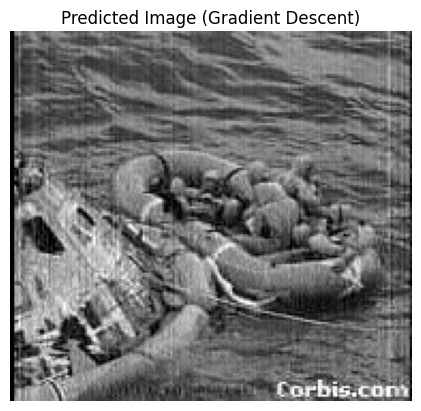

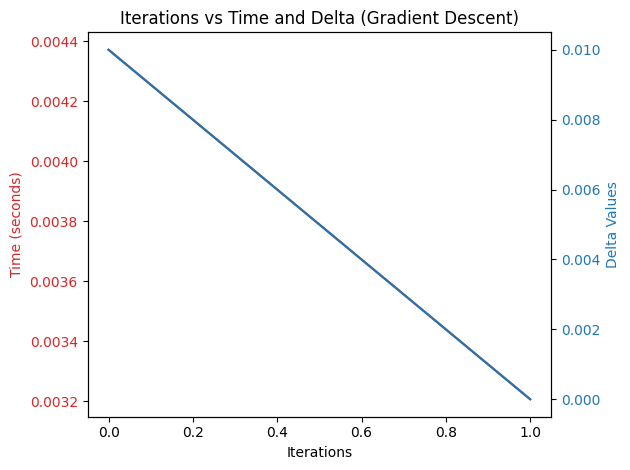


--- Efficiency Information for Gradient Descent ---
Total Iterations: 2
Delta Value at Last Iteration: 1e-06
Total Time: 0.00758 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Not satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied
______________________________________


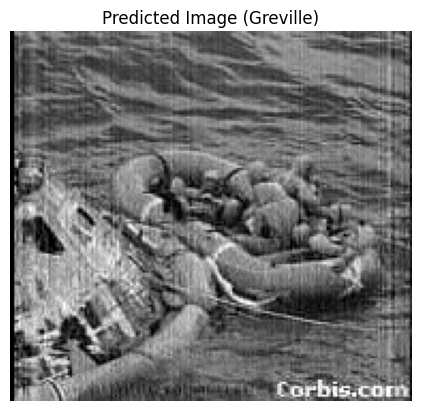

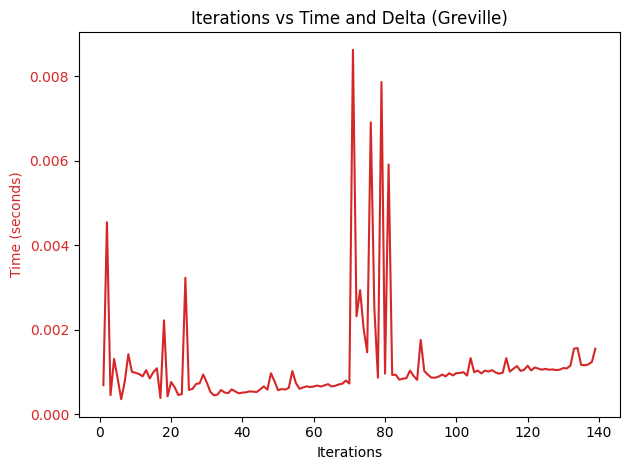


--- Efficiency Information for Method ---
Total Iterations: 139
Delta Value at Last Iteration: e
Total Time: 0.16007 seconds
Condition AA+A = A: Not satisfied
Condition A+AA+ = A+: Not satisfied
Condition AA+ is symmetric: Not satisfied
Condition A+A is symmetric: Not satisfied
______________________________________


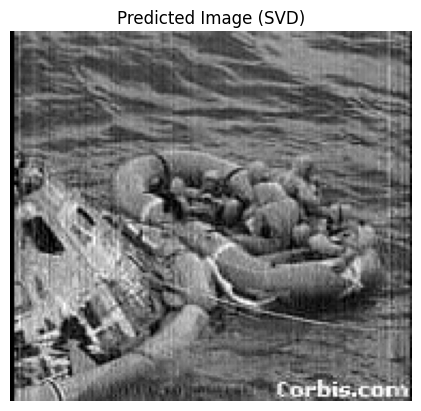

Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

def muraPenrosa(aMatrix, delta_start, epsilon=1e-5, max_iterations=1000):
    E = np.eye(aMatrix.shape[0])

    #Задається початкове значення delta
    delta = delta_start

    execution_times, delta_values, iteration_numbers = [], [], []

    for i in range(max_iterations):
        start_time = time.time()

        #Розраховується початкове наближення
        aPseudoInverse = aMatrix.T @ np.linalg.inv(aMatrix @ aMatrix.T + delta**2 * E)

        #На кроці k нове значення дельта_k
        delta_half = delta / 2

        execution_times.append(time.time() - start_time) #поточний час виконання кожної ітерації
        delta_values.append(delta) # поточна дельта на кожній ітерації
        iteration_numbers.append(i) # поточний номер ітерації

        #Розрахунок наближення псевдооберненої матриці А на кроці k
        if np.linalg.norm(aPseudoInverse - aMatrix.T @ np.linalg.inv(aMatrix @ aMatrix.T + delta_half**2 * E)) < epsilon:
            break

        delta = delta_half

    return aPseudoInverse, iteration_numbers, execution_times, delta_values

def gradient_ascent_method(aMatrix, delta_start, stepCoef=0.001, epsilon=1e-5, max_iter=1000, min_delta=1e-6, max_delta=1000):
    E = np.eye(aMatrix.shape[0])
    delta = delta_start
    start_stepCoef = stepCoef
    pseudo_inverse_history = []

    iteration_times, delta_values, iteration_indices = [], [], []

    for iter_index in range(max_iter):
        start_time = time.time()

        aPseudoInverse = aMatrix.T @ np.linalg.inv(aMatrix @ aMatrix.T + delta**2 * E)
        # grad використовується для оновлення delta в кожній ітерації градієнтного підйому
        grad = delta * 2 * np.trace(aPseudoInverse.T @ aPseudoInverse) # 2*delta ми використовуєм для масштабування

        # Експоненційне зменшення кроку
        # Швидкість з якою змінюється delta на кожній ітерації алгоритму
        start_stepCoef = stepCoef * np.exp(-0.01 * iter_index) # швидкість змінюється експоненціально,
        #тобто спочатку швидкість оновлення буде великою, при наближені до остаточного рішення - швидкість буде зменшуватись

        # Оновлення delta
        # Зменшуємо його на величину пропорційну градієнту, що дозволяє алгоритму шукати оптимальне значення.
        new_delta = delta - start_stepCoef * grad
        # Ставимо межі дельта,
        # Якщо дельта виходить за межі, ми його прирівнюємо до найбільш наближеної границі
        new_delta = np.clip(new_delta, min_delta, max_delta)

        iteration_times.append(time.time() - start_time)
        delta_values.append(delta)
        iteration_indices.append(iter_index)

        pseudo_inverse_history.append(aPseudoInverse.copy())  # Збереження проміжних матриць

        if abs(new_delta - delta) < epsilon:
            break

        delta = new_delta

    return aPseudoInverse, iteration_indices, iteration_times, delta_values, pseudo_inverse_history

def greville_algorithm(aMatrix, epsilon=1e-5):

    first_row = aMatrix[0]
    denominator = first_row.T @ first_row

    # Ініціалізація псевдооберненої матриці
    aPseudoInverse = np.vstack(first_row / denominator if denominator != 0 else first_row)

    current_matrix = np.array([first_row])
    num_rows = aMatrix.shape[0]

    # Списки для зберігання результатів
    iteration_time_list = []  # Час на кожну ітерацію Греввіля
    iteration_index_list = []  # Номери ітерацій

    for j in range(1, num_rows):
        start_time = time.time()  # Початок часу для кожної ітерації

        current_row = aMatrix[j].reshape(-1, 1)  # Перетворення рядка на стовпчик
        E = np.identity(current_matrix.shape[1])
        Z_A = E - aPseudoInverse @ current_matrix

        current_matrix = np.vstack([current_matrix, aMatrix[j]])
        # Обчислення знаменника для оновлення
        denominator = np.dot(current_row.T, (Z_A @ current_row))[0, 0]

        if np.abs(denominator) < epsilon:
            correction_matrix = aPseudoInverse @ aPseudoInverse.T
            denominator = 1 + np.dot(current_row.T, (correction_matrix @ current_row))
            aPseudoInverse = np.hstack([
                aPseudoInverse - np.dot(Z_A, np.dot(current_row, (current_row.T @ aPseudoInverse))) / denominator,
                np.dot(correction_matrix, current_row) / denominator
            ])
        else:
            aPseudoInverse = np.hstack([
                aPseudoInverse - np.dot(Z_A, np.dot(current_row, (current_row.T @ aPseudoInverse))) / denominator,
                np.dot(Z_A, current_row) / denominator
            ])

        # Зберігання часу і номеру ітерації
        iteration_time_list.append(time.time() - start_time)
        iteration_index_list.append(j)

    return {
        "pseudo_inverse": aPseudoInverse,
        "iteration_indices": iteration_index_list,
        "iteration_times": iteration_time_list,
        "final_denominator": denominator  # Додаємо останнє значення знаменника
    }

def svd_pseudo_inverse(matrix):
    # Використовуємо SVD для знаходження псевдооберненої матриці
    U, singular_values, Vt = np.linalg.svd(matrix, full_matrices=False)

    # Обчислюємо псевдообернені значення для сингулярних чисел
    singular_values_pseudo_inv = np.diag([1/s if s > 1e-10 else 0 for s in singular_values])

    # Псевдообернена матриця через SVD
    pseudo_inverse = Vt.T @ singular_values_pseudo_inv @ U.T
    return pseudo_inverse

def normalize(matrix):
    return (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

def plot_iterations_and_time(iteration_indices, exec_times, delta_values=None, method_name="Method"):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Time (seconds)', color='tab:red')
    ax1.plot(iteration_indices, exec_times, color='tab:red', label="Execution Time")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    if delta_values is not None:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Delta Values', color='tab:blue')
        ax2.plot(iteration_indices, delta_values, color='tab:blue', label="Delta Values")
        ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Iterations vs Time and Delta ({method_name})')
    fig.tight_layout()
    plt.show()

def display_efficiency(iteration_indices, exec_times, delta_values=None, method_name="Method"):
    print(f"\n--- Efficiency Information for {method_name} ---")
    print(f"Total Iterations: {len(iteration_indices)}")
    if delta_values:
        print(f"Delta Value at Last Iteration: {delta_values[-1]}")
    print(f"Total Time: {sum(exec_times):.5f} seconds")

def verify_pseudo_inverse_properties(A, A_pseudo):
    conditions = [
        (np.allclose(A @ A_pseudo @ A, A), "Condition AA+A = A"),
        (np.allclose(A_pseudo @ A @ A_pseudo, A_pseudo), "Condition A+AA+ = A+"),
        (np.allclose(A @ A_pseudo, (A @ A_pseudo).T), "Condition AA+ is symmetric"),
        (np.allclose(A_pseudo @ A, (A_pseudo @ A).T), "Condition A+A is symmetric")
    ]

    for condition, description in conditions:
        print(f"{description}: {'Satisfied' if condition else 'Not satisfied'}")

    return [condition for condition, _ in conditions]

def calculate_score(time, iterations, accuracy):
    return time * iterations / accuracy

def compare_methods(scores):
    mura_score, gradient_score = scores

    print("\n--- Method Comparison ---")
    print(f"Mura-Penrose Score: {mura_score:.5f}")
    print(f"Gradient Descent Score: {gradient_score:.5f}")

    if mura_score > gradient_score:
        print("Mura-Penrose method is more efficient based on the comparison.")
    else:
        print("Gradient Descent method is more efficient based on the comparison.")

def display_image(matrix, title):
    normalized_image = np.clip(matrix * 255, 0, 255).astype(np.uint8)
    img = Image.fromarray(normalized_image)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def main_process():
    # Load images
    image_input = Image.open("x1.bmp")
    image_output = Image.open("y2.bmp")

    # Convert images to matrices and normalize
    input_matrix = normalize(np.array(image_input, dtype=float))
    output_matrix = normalize(np.array(image_output, dtype=float))

    # Mura-Penrose
    pseudo_inv_mura, iter_counts, iter_times, delta_vals = muraPenrosa(input_matrix, 0.01)
    A_mura = output_matrix @ pseudo_inv_mura
    predicted_mura = A_mura @ input_matrix
    mura_accuracy = np.linalg.norm(predicted_mura - output_matrix)  # Точність Mura-Penrose
    mura_score = calculate_score(sum(iter_times), len(iter_counts), mura_accuracy)

    # Gradient Descent Method
    aPseudoInverse, iteration_indices, iteration_times, delta_values, pseudo_inverse_history = gradient_ascent_method(input_matrix, 0.01)
    A_gradient = output_matrix @ aPseudoInverse
    predicted_gradient = A_gradient @ input_matrix
    gradient_accuracy = np.linalg.norm(predicted_gradient - output_matrix)  # Точність Gradient Descent
    gradient_score = calculate_score(sum(iteration_times), len(iteration_indices), gradient_accuracy)

    # Порівняння методів
    compare_methods((mura_score, gradient_score))

    # Виведення результатів лише для кращого методу
    if mura_score > gradient_score:
        # Gradient Descent - кращий метод
        display_image(predicted_gradient, title='Predicted Image (Gradient Descent)')
        plot_iterations_and_time(iteration_indices, iteration_times, delta_values, "Gradient Descent")
        display_efficiency(iteration_indices, iteration_times, delta_values, "Gradient Descent")
        verify_pseudo_inverse_properties(input_matrix, aPseudoInverse)
    else:
        # Mura-Penrose - кращий метод
        display_image(predicted_mura, title='Predicted Image (Mura-Penrose)')
        plot_iterations_and_time(iter_counts, iter_times, delta_vals, "Mura-Penrose")
        display_efficiency(iter_counts, iter_times, delta_vals, "Mura-Penrose")
        verify_pseudo_inverse_properties(input_matrix, pseudo_inv_mura)
    print("______________________________________")

   # Greville Method
    results = greville_algorithm(input_matrix, 0.01)
    pseudo_inv_greville = results["pseudo_inverse"]
    iter_greville = results["iteration_indices"]
    iter_times_greville = results["iteration_times"]

    A_greville = output_matrix @ pseudo_inv_greville
    predicted_greville = A_greville @ input_matrix
    display_image(predicted_greville, title='Predicted Image (Greville)')


    plot_iterations_and_time(iter_greville, iter_times_greville, None, "Greville")
    display_efficiency(iter_greville, iter_times_greville, "Greville")
    verify_pseudo_inverse_properties(input_matrix, pseudo_inv_greville)
    print("______________________________________")

     # SVD Method
    pseudo_inv_svd = svd_pseudo_inverse(input_matrix)
    A_svd = output_matrix @ pseudo_inv_svd
    predicted_svd = A_svd @ input_matrix
    display_image(predicted_svd, title='Predicted Image (SVD)')

    # Перевіряємо властивості псевдооберненої матриці
    verify_pseudo_inverse_properties(input_matrix, pseudo_inv_svd)

if __name__ == "__main__":
    main_process()
